### Check GPU

In [25]:
!nvidia-smi

/bin/bash: /home/djbacad/miniconda3/envs/tensorflow-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed May 10 12:26:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.50                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060         On | 00000000:01:00.0  On |                  N/A |
| N/A   68C    P0               37W /  N/A|   5758MiB /  6144MiB |      3%      Default |
|                         

In [26]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Import libraries

In [27]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow_addons as tfa
import keras_cv
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
SEED_VALUE = 888888

### Initialize tunable hyperparameters

In [5]:
EPOCHS = 150
BATCH_SIZE = 16
IMG_SIZE = 224

#Optimizer HPs (Adabeleif):
INIT_LEARNING_RATE = 4.5e-3
TL_EPSILON = 1e-11
TL_WEIGHT_DECAY = 1e-2

### Load the data and assign the train, val, and test sets

*Used the image_dataset_from directory to create the 70-10-20 train-val-test split.*

In [28]:
data_loc = '../data/vision'

# Train
train_set_raw = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="training",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Val
val_set_raw = tf.keras.utils.image_dataset_from_directory(
  directory=data_loc,
  validation_split=0.3,
  subset="validation",
  seed=SEED_VALUE,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  shuffle=True
)

# Test
# Create the test set by breaking down the validation set.
val_batches = tf.data.experimental.cardinality(val_set_raw)
val_set_raw = val_set_raw.skip((2*val_batches) // 3)
test_set_raw = val_set_raw.take((2*val_batches) // 3)

Found 207 files belonging to 3 classes.
Using 145 files for training.
Found 207 files belonging to 3 classes.
Using 62 files for validation.


In [7]:
class_names = np.array(train_set_raw.class_names)
print(class_names)

['C' 'D' 'G']


### Use buffered prefetching for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set_raw.prefetch(buffer_size=AUTOTUNE)
val_set = val_set_raw.prefetch(buffer_size=AUTOTUNE)
test_set = test_set_raw.prefetch(buffer_size=AUTOTUNE)

### Define the on-the-fly data augmentation steps

*Augmentation help address the lack of training data scarcity. Only included realistic items.*

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomTranslation(0.15,0.15),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.3),
  layers.RandomBrightness(factor=0.15),
  keras_cv.layers.RandomShear(0.15,0.12)
])

### Create the base model

In [10]:
base_model = EfficientNetV2B0(weights='imagenet',
                             include_top=False, 
                             pooling='avg',
                             input_shape=(IMG_SIZE, IMG_SIZE, 3)) 


# Freeze
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

### Attach the new top layers / classification head

*Make sure that the inputs are aligned with the preprocess_input of EfficientNetV2B0*

In [11]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)

2023-05-10 12:19:56.964098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:19:57.003109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform_1/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/tra

2023-05-10 12:19:57.771900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:19:57.809636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform_1/strided_slice' wi

### Define callbacks

*Record the weights from the epoch where val loss and val acc is at its lowest and highest respectively.*

In [12]:
modelcheckpoint_vl = (
    ModelCheckpoint(filepath='../models/vision/min_val_loss.h5',
                    monitor='val_loss',
                    mode='min',
                    verbose=1,
                    save_best_only=True)
)

modelcheckpoint_va = (
    ModelCheckpoint(filepath='../models/vision/max_val_acc.h5',
                    monitor='val_acc',
                    mode='max',
                    verbose=1,
                    save_best_only=True)
)

### Compile the model

*Use the custom AdaBelief optimizer for faster convergence and better accuracy.*

In [13]:
optim = tfa.optimizers.AdaBelief(learning_rate=INIT_LEARNING_RATE,
                                 weight_decay=TL_WEIGHT_DECAY,
                                 epsilon=TL_EPSILON)

model.compile(optimizer=optim,
             loss="sparse_categorical_crossentropy",
             metrics=['acc'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 3,843
Non-trainable params: 5,919,312
_______________________________________________

### Train the model

In [15]:
history = model.fit(train_set,
                    epochs=EPOCHS,
                    validation_data=val_set,
                    callbacks = [modelcheckpoint_vl, modelcheckpoint_va],
                    )

Epoch 1/150


2023-05-10 12:19:59.405054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [145]
	 [[{{node Placeholder/_4}}]]
2023-05-10 12:19:59.405646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [145]
	 [[{{node Placeholder/_4}}]]


2023-05-10 12:20:00.451571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:20:00.496885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

2023-05-10 12:20:05.265893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:20:05.316883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

10/10 [==============================] - ETA: 0s - loss: 1.2220 - acc: 0.3241

2023-05-10 12:20:16.539685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [62]
	 [[{{node Placeholder/_4}}]]
2023-05-10 12:20:16.540327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [62]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_loss improved from inf to 1.12380, saving model to ../models/vision/min_val_loss.h5

Epoch 1: val_acc improved from -inf to 0.33333, saving model to ../models/vision/max_val_acc.h5
10/10 [==============================] - 23s 784ms/step - loss: 1.2220 - acc: 0.3241 - val_loss: 1.1238 - val_acc: 0.3333
Epoch 2/150
 9/10 [==========================>...] - ETA: 0s - loss: 1.2029 - acc: 0.3750
Epoch 2: val_loss improved from 1.12380 to 1.01002, saving model to ../models/vision/min_val_loss.h5

Epoch 2: val_acc improved from 0.33333 to 0.43333, saving model to ../models/vision/max_val_acc.h5
10/10 [==============================] - 3s 307ms/step - loss: 1.2053 - acc: 0.3724 - val_loss: 1.0100 - val_acc: 0.4333
Epoch 3/150
 9/10 [==========================>...] - ETA: 0s - loss: 1.0918 - acc: 0.4236
Epoch 3: val_loss improved from 1.01002 to 0.99575, saving model to ../models/vision/min_val_loss.h5

Epoch 3: val_acc improved from 0.43333 to 0.56667, saving model to ../models/vi

### Visualize accuracy and loss

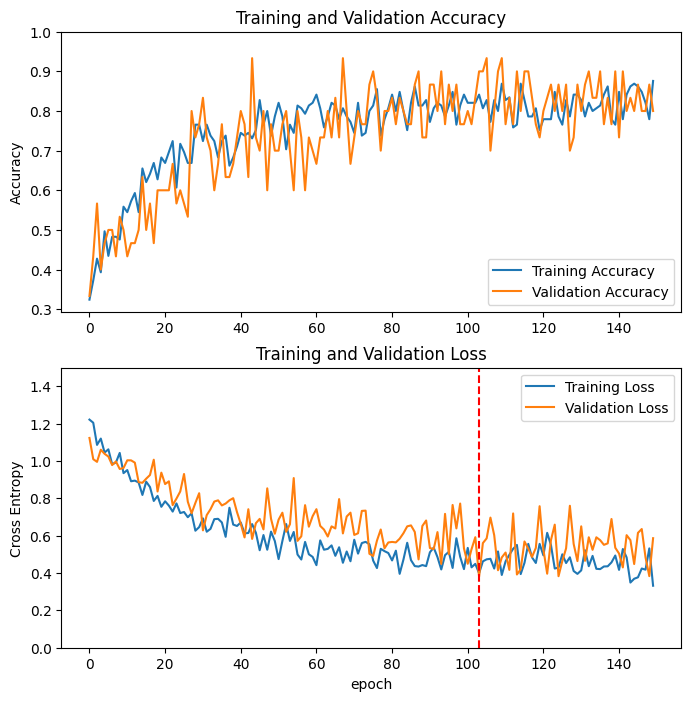

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


loss = history.history['loss']
val_loss = history.history['val_loss']
min_value = min(val_loss)
min_index = val_loss.index(min_value)
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.axvline(x=min_index, c = 'r', ls = '--')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
best_model = tf.keras.models.load_model('../models/vision/min_val_loss.h5')

2023-05-10 12:23:38.093864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:23:38.129701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform_1/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/tra

2023-05-10 12:23:41.166226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:23:41.201962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform_1/strided_slice' wi

### Check accuracy on test set

In [30]:
print('Testing Accuracy: ',(best_model.evaluate(test_set_raw))[1]*100, '%')

2023-05-10 12:36:17.019898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [62]
	 [[{{node Placeholder/_4}}]]
2023-05-10 12:36:17.020360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [62]
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 2s 39ms/step - loss: 0.2692 - acc: 0.8333
Testing Accuracy:  83.33333134651184 %


### Fine Tune by unfreezing the top layers of the model

In [19]:
base_model.trainable = True

*The headless EfficientNetV2B0 contains 271 layers. The fine tuning process is set to start @ 230th layer*

In [20]:
# Freeze all the layers before the `fine_tune_at` layer
fine_tune_at = 230
for layer in base_model.layers[:fine_tune_at]:
   layer.trainable = False


### Recompile the model

*Lower learning rate is used to avoid quick overfitting.*

In [21]:
optim = tfa.optimizers.AdaBelief(learning_rate=INIT_LEARNING_RATE/8,
                                 weight_decay=TL_WEIGHT_DECAY,
                                 epsilon=TL_EPSILON)

model.compile(optimizer=optim,
             loss="sparse_categorical_crossentropy",
             metrics=['acc'])

*Additional 20 epochs for fine tuning. Fine tuning process is started at the 113th epoch (point of minimum validation loss from earlier training)*

In [22]:
ft_modelcheckpoint_vl = (
    ModelCheckpoint(filepath='../models/vision/ft_min_val_loss.h5',
                    monitor='val_loss',
                    mode='min',
                    verbose=1,
                    save_best_only=True)
)

ft_modelcheckpoint_va = (
    ModelCheckpoint(filepath='../models/vision/ft_max_val_acc.h5',
                    monitor='val_acc',
                    mode='max',
                    verbose=1,
                    save_best_only=True)
)

FT_EPOCHS = 20
TOTAL_EPOCHS =  min_index + FT_EPOCHS

history_fine = model.fit(train_set,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=min_index-1,
                         validation_data=val_set,
                         callbacks=[ft_modelcheckpoint_vl,
                                    ft_modelcheckpoint_va])

Epoch 103/123


2023-05-10 12:23:46.636573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:23:46.692998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

2023-05-10 12:23:53.729306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node model/sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:23:53.784933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'model/sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/model/sequential/random_shear/loo

10/10 [==============================] - ETA: 0s - loss: 0.5408 - acc: 0.7793
Epoch 103: val_loss improved from inf to 0.43576, saving model to ../models/vision/ft_min_val_loss.h5

Epoch 103: val_acc improved from -inf to 0.83333, saving model to ../models/vision/ft_max_val_acc.h5
10/10 [==============================] - 25s 698ms/step - loss: 0.5408 - acc: 0.7793 - val_loss: 0.4358 - val_acc: 0.8333
Epoch 104/123
10/10 [==============================] - ETA: 0s - loss: 0.3853 - acc: 0.8345
Epoch 104: val_loss did not improve from 0.43576

Epoch 104: val_acc did not improve from 0.83333
10/10 [==============================] - 2s 139ms/step - loss: 0.3853 - acc: 0.8345 - val_loss: 0.5339 - val_acc: 0.8000
Epoch 105/123
10/10 [==============================] - ETA: 0s - loss: 0.4259 - acc: 0.8345
Epoch 105: val_loss did not improve from 0.43576

Epoch 105: val_acc did not improve from 0.83333
10/10 [==============================] - 2s 151ms/step - loss: 0.4259 - acc: 0.8345 - val_loss:

In [31]:
best_model = tf.keras.models.load_model('../models/vision/ft_min_val_loss.h5')

2023-05-10 12:36:26.714423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:36:26.756007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/random_shear/loop_body/transform_1/strided_slice' with dtype int32 and shape [2]
	 [[{{node random_shear/loop_body/tra

2023-05-10 12:36:30.734487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice' with dtype int32 and shape [2]
	 [[{{node sequential/random_shear/loop_body/transform/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform/strided_slice}}]]
2023-05-10 12:36:30.777392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'sequential/random_shear/loop_body/transform_1/ImageProjectiveTransformV3/pfor/while/sequential/random_shear/loop_body/transform_1/strided_slice' wi

In [47]:
print('Testing Accuracy: ',(best_model.evaluate(test_set_raw))[1]*100, '%')

2/2 [==============================] - 0s 33ms/step - loss: 0.3518 - acc: 0.9000
Testing Accuracy:  89.99999761581421 %
